Open the dataset `bike_rides.csv` with the following commands:

In [1]:
import os

os.makedirs("../../datasets", exist_ok=True)

In [2]:
%%bash

wget -qO "../../datasets/bike_rides.csv" "https://github.com/INRIA/scikit-learn-mooc/raw/master/datasets/bike_rides.csv"

In [3]:
import pandas as pd

cycling = pd.read_csv("../../datasets/bike_rides.csv", 
    index_col=0, parse_dates=True)
cycling.index.name = ""
target_name = "power"
data, target = cycling.drop(columns=target_name), cycling[target_name]
data.head()

,heart-rate,cadence,speed,acceleration,slope
,,,,,
2020-08-18 14:43:19,102.0,64.0,4.325,0.0880,-0.033870
2020-08-18 14:43:20,103.0,64.0,4.336,0.0842,-0.033571
2020-08-18 14:43:21,105.0,66.0,4.409,0.0234,-0.033223
2020-08-18 14:43:22,106.0,66.0,4.445,0.0016,-0.032908
2020-08-18 14:43:23,106.0,67.0,4.441,0.1144,0.000000


A detailed description of this dataset is given in the appendix. As a reminder, the problem we are trying to solve with this dataset is to use measurements from cheap sensors (GPS, heart-rate monitor, etc.) in order to predict a cyclist power. Power can indeed be recorded via a cycling power meter device, but this device is rather expensive.

Instead of using blindly machine learning, we will first introduce some flavor of classic mechanics: the Newton's second law.

\begin{equation}
P_{meca} = V_d \bigg( \frac{1}{2} \rho \ S \ C_x \ V_a^2 + C_r \ m \ g \ \cos({\alpha}) + m \ g \ \sin({\alpha}) + m \ a \bigg)
\end{equation}

where $\rho$ is the air density in $\textrm{kg} \ \textrm{m}^{-3}$, $S$ is frontal surface of the cyclist in $\textrm{m}^2$, $C_x$ is the drag coefficient, $V_a$ is the air speed in $\textrm{m} \ \textrm{s}^{-1}$, $C_r$ is the rolling coefficient, $m$ is the mass of the rider and bicycle in $\textrm{kg}$, $g$ is the standard acceleration due to gravity which is equal to 9.81 $\textrm{m} \ \textrm{s}^{-2}$, $\alpha$ is the slope in radian, $V_d$ is the rider speed in $\textrm{m} \ \textrm{s}^{-1}$, and $a$ is the rider acceleration in $\textrm{m} \ \textrm{s}^{-2}$.

This equation might look a bit complex at first but we can explain with words what the different terms within the parenthesis are:
- the first term is the power that a cyclist is required to produce to fight wind.
- the second term is the power that a cyclist is required to produce to fight the rolling resistance created by the tires on the floor.
- the third term is the power that a cyclist is required to produce to go up a hill if the slope is positive. If the slope is negative the cyclist does not need to produce any power to go forward.
- the fourth and last term is the power that a cyclist requires to change his speed (i.e. acceleration).

We can simplify the model above by using the data that we have at hand. It would look like the following:

\begin{equation}
P_{meca} = \beta_1 V_d^3 + \beta_2 V_d + \beta_3 \sin({\alpha}) V_d + \beta_4 \ a \ V_d
\end{equation}

This model is closer to what we saw previously: it is a linear model trained on a non-linear feature transformation. We will build, train and evaluate such a model as part of this exercise. Thus, you need to:
- create a new data matrix containing the cube of the speed, the speed, the speed multiplied by the sine of the angle of the slope, and the speed multiplied by the acceleration. To compute the angle of the slope, you need to take the arc targent of the slope (`alpha = np.arctan(slope)`). In addition, we can limit ourself to positive acceleration only by clipping to 0 the negative acceleration values (they would corrrespond to some power created by the braking that we are not modeling here).
- using the new data matrix, create a linear predictive model based on a `sklearn.preprocessing.StandardScaler` and a `sklearn.linear_model.RidgeCV`.
- use a `sklearn.model_selection.ShuffleSplit` cross-validation strategy with only 4 splits (n_splits=4) to evaluate the statistical performance of the model. Use the mean absolute error (MAE) as a statistical performance metric. Also, pass the parameter `return_estimator=True` and `return_train_score=True` to answer the subsequent questions. Be aware that the `ShuffleSplit` strategy is a naive strategy and we will investigate the consequence of making this choice in the subsequent questions.

The code allowing to build the data matrix and compute the mean value of the column containing the information of $\sin({\alpha}) V_d$ is the following:

In [4]:
import numpy as np

# build the data matrix
data_linear_model = pd.concat({
    "speed^3": data["speed"]**3,
    "speed": data["speed"],
    "speed*sin(alpha)": data["speed"]*np.sin(np.arctan(data["slope"])),
    "speed*acceleration": data["speed"] * data["acceleration"].clip(lower=0)
}, axis=1)

data_linear_model.mean()["speed*sin(alpha)"]

-0.002709709612566326

We can display an interactive diagram with the following command:

In [5]:
from sklearn import set_config
set_config(display='diagram')

Here is the code that allows to answer the average mean absolute error (MAE) on the test sets obtained through cross-validation.

In [6]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV

# create the model
linear_model = make_pipeline(StandardScaler(), 
    RidgeCV())
linear_model

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('ridgecv', RidgeCV(alphas=array([ 0.1,  1. , 10. ])))])

Pass `scoring="neg_mean_absolute_error"` to the `cross_validate` function to compute the (negative of) the requested metric. 

In [7]:
%%time
from sklearn.model_selection import ShuffleSplit, cross_validate

# evaluate the model with cross-validation
cv = ShuffleSplit(n_splits=4, random_state=0)
cv_results_linear_model = cross_validate(
    linear_model, data_linear_model, target, 
    cv=cv, n_jobs=2, scoring="neg_mean_absolute_error",
    return_estimator=True, return_train_score=True)
errors = -cv_results_linear_model['train_score']
print(f"Linar model - MAE on train sets:\n {errors} \n",
    f"mean +/- std: {errors.mean():.3f} +/- {errors.std():.3f} Watts")
errors = -cv_results_linear_model['test_score']
print(f"Linear model - MAE on test sets: \n {errors} \n", 
    f"mean +/- std: {errors.mean():.3f} +/- {errors.std():.3f} Watts")

Linar model - MAE on train sets:
 [72.35634493 72.51703894 72.42974777 72.6121094 ] 
 mean +/- std: 72.479 +/- 0.096 Watts
Linear model - MAE on test sets: 
 [73.23006461 72.1311734  72.89061823 71.2370263 ] 
 mean +/- std: 72.372 +/- 0.767 Watts
CPU times: user 21.5 ms, sys: 51.8 ms, total: 73.2 ms
Wall time: 928 ms


Given the model

\begin{equation}
P_{meca} = \beta_1 V_d^3 + \beta_2 V_d + \beta_3 \sin({\alpha}) V_d + \beta_4 \ a \ V_d
\end{equation}

that we created, inspect the weights of the linear models fitted during the cross-validation. We can inspect the coefficients by passing `return_estimator` in `cross_validate` call. Then, we can plot the weights distribution with a box plot with the following snippet:

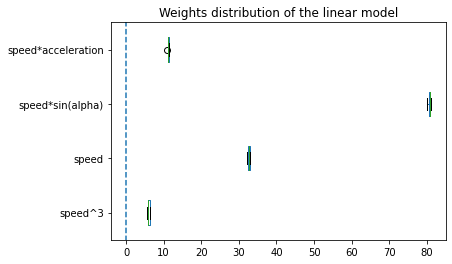

In [8]:
import matplotlib.pyplot as plt

coefs = [est[-1].coef_ for est in 
    cv_results_linear_model['estimator']]
coefs = pd.DataFrame(coefs, 
    columns=data_linear_model.columns)

ax = coefs.plot.box(vert=False)
ax.axvline(0, -1, 1, linestyle="--")
_ = plt.title("Weights distribution of the linear model")

All weights are greater than 0. It is not surprising since the coefficients are related to products of positive physical quantities such as the mass of the rider and the bike, gravity, the air density, etc. Indeed, by putting together the first equation and the value of $\beta$s, we would expect a relationship that could be close to:
- $\beta_1 \approx \frac{1}{2} \rho \ S \ C_x$
- $\beta_2 \approx C_r \ m \ g$
- $\beta_3 \approx m \ g$
- $\beta_4 \approx m \ a$

This relationship is also explaining why we could have expected $\beta_1 < \beta_2 < \beta_3$. Indeed, $C_r$ is a small constant so, we could expect $\beta_2 < \beta_3$. $\rho \ S \ C_x$ are very small values in comparison with $C_r$ or $m \ g$ and one could have expected $\beta_1 < \beta_2$.

Now, we will create a predictive model that uses all available sensor measurements such as cadence (the speed at which a cyclist turns pedals measured in rotation per minute) and heart-rate (the number of beat per minute of the heart of the cyclist while exercising). Also, we will use a non-linear regressor, a `sklearn.ensemble.HistGradientBoostingRegressor`.

Fix the number of maximum iterations to 1000 (`max_iter=1000`) and activate the early stopping (`early_stopping=True`). Repeat the previous evaluation using the regressor.

Here is the code to answer the average mean absolute error (MAE) on the test sets obtained through cross-validation.

In [9]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor

hgbdt = HistGradientBoostingRegressor(
    max_iter=1000, early_stopping=True, random_state=42)
hgbdt

HistGradientBoostingRegressor(early_stopping=True, max_iter=1000,
                              random_state=42)

In [10]:
%%time
cv = ShuffleSplit(n_splits=4, random_state=0)
cv_results_hgbdt = cross_validate(
    hgbdt, data, target, 
    cv=cv, n_jobs=2, scoring="neg_mean_absolute_error",
    return_estimator=True, return_train_score=True)
errors = -cv_results_hgbdt['train_score']
print(f"Histogram GBDT - MAE on train sets:\n {errors} \n",
    f"mean +/- std: {errors.mean():.3f} +/- {errors.std():.3f} Watts")
errors = -cv_results_hgbdt['test_score']
print(f"Histogram GBDT - MAE on test sets: \n {errors} \n", 
    f"mean +/- std: {errors.mean():.3f} +/- {errors.std():.3f} Watts")

Histogram GBDT - MAE on train sets:
 [40.3646547  41.44043337 40.86589411 39.57349479] 
 mean +/- std: 40.561 +/- 0.686 Watts
Histogram GBDT - MAE on test sets: 
 [44.39516221 44.13036203 43.75817    43.06094014] 
 mean +/- std: 43.836 +/- 0.502 Watts
CPU times: user 43.8 ms, sys: 23.2 ms, total: 67 ms
Wall time: 3.02 s


On average, the MAE of this model on the test data is ~44 Watts. Therefore, it seems that the additional features and the change of regressor have a positive impact on the statistical performance.

Comparing both the linear model and the histogram gradient boosting model and taking into consideration the train and test MAE obtained via cross-validation, we need to print the train and test error for both models. Look at the values of the `train_score` and the `test_score` collected in the dictionaries returned by the `cross_validate` function. The statistical performance of the histogram gradient-boosting model is limited by its overfitting, whereas the statistical performance of the linear model is limited by its underfitting.

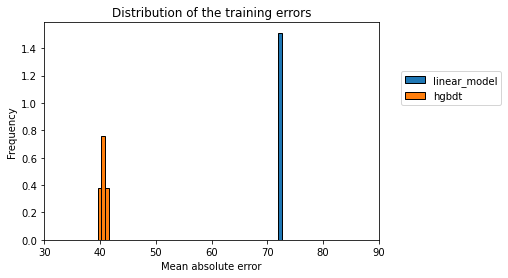

In [11]:
train_errors_linear_model = pd.Series(
    -cv_results_linear_model['train_score'], 
    name="linear_model")
train_errors_hgbdt = pd.Series(
    -cv_results_hgbdt['train_score'], 
    name="hgbdt")
train_errors = pd.concat([
    train_errors_linear_model,
    train_errors_hgbdt
    ], axis=1)
train_errors.plot.hist(bins=50, density=True, edgecolor="black")
plt.legend(bbox_to_anchor=(1.05, 0.8), loc="upper left")
plt.xlabel("Mean absolute error")
plt.xlim(30, 90)
_ = plt.title("Distribution of the training errors")

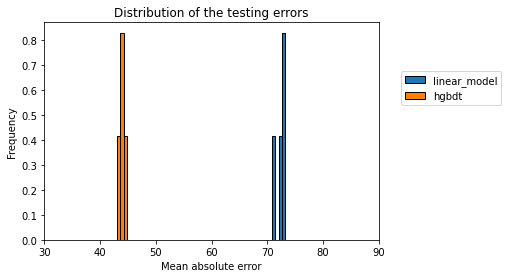

In [12]:
test_errors_linear_model = pd.Series(
    -cv_results_linear_model['test_score'], 
    name="linear_model")
test_errors_hgbdt = pd.Series(
    -cv_results_hgbdt['test_score'], 
    name="hgbdt")
test_errors = pd.concat([
    test_errors_linear_model,
    test_errors_hgbdt
    ], axis=1)
test_errors.plot.hist(bins=50, density=True, edgecolor="black")
plt.legend(bbox_to_anchor=(1.05, 0.8), loc="upper left")
plt.xlabel("Mean absolute error")
plt.xlim(30, 90)
_ = plt.title("Distribution of the testing errors")

With the histogram gradient boosting, the testing error is higher than the training error. This symptomactic of a model capable of overfitting. The testing and training error of the linear model are very close. However, the errors are much higher than the histogram gradient boosting. The linear model is clearly underfitting.

In the previous cross-validation, we made the choice of using a `ShuffleSplit` cross-validation strategy. It means that randomly selected samples were selected as a testing test ignoring any time dependency between the lines of the dataframe.

We would like to have a cross-validation strategy that evaluates the capacity of our model to predict on a completely new bike role: the samples in the validation set should only come from rides not present in the training set.

We can check the unique day in the `DatatimeIndex` (the index of the dataframe `data`). Indeed, we assume that on a given day the rider went cycling at most once per day. We can inspect the index of the dataframe `data`. The following code snippet allows to count the number of different days appearing in the index of the dataframe.

In [13]:
import numpy as np

unique_ride_dates = np.unique(cycling.index.date)
print(f"There are {len(unique_ride_dates)} bike rides")

There are 4 bike rides


Instead of using the naive `ShuffleSplit` strategy, we will use a strategy that takes into account the group defined by each individual date. It corresponds to a bike ride. We would like to have a cross-validation strategy that evaluates the capacity of our model to predict on a completely new bike ride: the samples in the validation set should only come from rides not present in the training set. Therefore, we can use a `LeaveOneGroupOut` strategy: at each iteration of the cross-validation, we will keep a bike ride for the evaluation and use all other bike rides to train our model.

Thus, you concretely need to:
- create a variable called `group` that is a 1D numpy array containing the index of each ride present in the dataframe. Therefore, the length of `group` will be equal to the number of samples in `data`. If we had 2 bike rides, we would expect the indices 0 and 1 in `group` to differentiate the bike ride. You can use `pd.factorize` to encode any Python types into integer indices.
- create a cross-validation object named `cv` using the `sklearn.model_selection.LeaveOneGroupOut` strategy.
- evaluate both the linear and histogram gradient boosting models with this strategy.

Using the previous evaluations (with both `ShuffleSplit` and `LeaveOneGroupOut`) and looking at the train and test errors for both models. The evaluation using the `LeaveOneGroupOut` is performed with the following code snippet:

In [14]:
%%time
from sklearn.model_selection import LeaveOneGroupOut

groups, _ = pd.factorize(data_linear_model.index.date)

cv = LeaveOneGroupOut()

cv_results_linear_model = cross_validate(
    linear_model, data_linear_model, target, groups=groups, 
    cv=cv, n_jobs=2, scoring="neg_mean_absolute_error", 
    return_estimator=True, return_train_score=True)

errors = -cv_results_linear_model['train_score']
print(f"Linar model - MAE on train sets:\n {errors} \n",
    f"mean +/- std: {errors.mean():.3f} +/- {errors.std():.3f} Watts")
errors = -cv_results_linear_model['test_score']
print(f"Linear model - MAE on test sets: \n {errors} \n", 
    f"mean +/- std: {errors.mean():.3f} +/- {errors.std():.3f} Watts")

Linar model - MAE on train sets:
 [72.4317474  72.28702403 68.96505889 75.31150408] 
 mean +/- std: 72.249 +/- 2.247 Watts
Linear model - MAE on test sets: 
 [72.44062969 73.32064854 81.30750799 64.99031478] 
 mean +/- std: 73.015 +/- 5.779 Watts
CPU times: user 30.6 ms, sys: 20 ms, total: 50.6 ms
Wall time: 107 ms


In [15]:
%%time

cv_results_hgbdt = cross_validate(
    hgbdt, data, target, groups=groups,
    cv=cv, n_jobs=2, scoring="neg_mean_absolute_error",
    return_estimator=True, return_train_score=True)
errors = -cv_results_hgbdt['train_score']
print(f"Histogram GBDT - MAE on train sets:\n {errors} \n",
    f"mean +/- std: {errors.mean():.3f} +/- {errors.std():.3f} Watts")
errors = -cv_results_hgbdt['test_score']
print(f"Histogram GBDT - MAE on test sets: \n {errors} \n", 
    f"mean +/- std: {errors.mean():.3f} +/- {errors.std():.3f} Watts")

Histogram GBDT - MAE on train sets:
 [40.7049334  39.02575852 38.81290186 41.98160572] 
 mean +/- std: 40.131 +/- 1.295 Watts
Histogram GBDT - MAE on test sets: 
 [47.32538538 48.14489479 53.83934818 47.50502499] 
 mean +/- std: 49.204 +/- 2.694 Watts
CPU times: user 39.7 ms, sys: 5.54 ms, total: 45.3 ms
Wall time: 2.4 s


Regarding model under- and over-fitting, we observe the same behaviour as with the `ShuffleSplit` strategy: the linear model is still limited by underfitting while the histogram gradient boosting regressor is still overfitting.

We also see that the histogram gradient boosting regressor is more clearly overfitting with the `LeaveOneOutGroup` cross-validation strategy.

Thus, even if the linear model is modelling the true physical problem, the shortcomings due to missing measurement (for instance wind speed) and the uncertainty of the measurements (for instance GPS error), this model is not as accurate than the histogram gradient boosting regressor that uses external measurements. The additional information such as the heart-rate and the cadence attenuate the previous shortcomings.

Using the previous evaluations (with both `ShuffleSplit` and `LeaveOneGroupOut`) and looking at the train and test errors for both models. Both cross-validation strategies are equivalent for the linear model, and `ShuffleSplit` is giving over-optimistic results for the gradient-boosting model.

We see that using the `LeaveOneGroupOut` strategy, the test error increased in comparison with using the `ShuffleSplit` strategy. However, the train error did not change. The `LeaveOneGroupOut` strategy is closer to the actual setting encountered when putting the model in production, we can conclude that the statistical performance provided by the `ShuffleSplit` cross-validation strategy was over-optimistic by estimating a lower average test error than what we would observe on future bike rides.

It is interesting to note that we do not see this behaviour for the linear model. The reason is that our linear model is underfitting.

Compare more precisely the errors estimated through cross-validation, in general, the standard deviation of the train and test errors increased using the `LeaveOneGroupOut` cross-validation. 

We observe a higher standard deviation of the test MAE when it is computed by respecting the ride dependency structure using `LeaveOneOutGroup`: we can see that the third fold has a low train error and a much higher test error than for the other folds.

The reason can be found by plotting histograms of the target variable independently for each ride and observe that one ride has significantly higher power values with a long and steep slope.

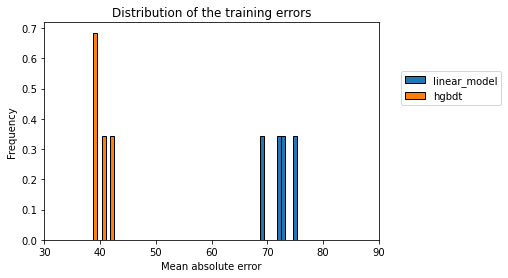

In [16]:
train_errors_linear_model = pd.Series(
    -cv_results_linear_model['train_score'], 
    name="linear_model")
train_errors_hgbdt = pd.Series(
    -cv_results_hgbdt['train_score'], 
    name="hgbdt")
train_errors = pd.concat([
    train_errors_linear_model,
    train_errors_hgbdt
    ], axis=1)
train_errors.plot.hist(bins=50, density=True, edgecolor="black")
plt.legend(bbox_to_anchor=(1.05, 0.8), loc="upper left")
plt.xlabel("Mean absolute error")
plt.xlim(30, 90)
_ = plt.title("Distribution of the training errors")

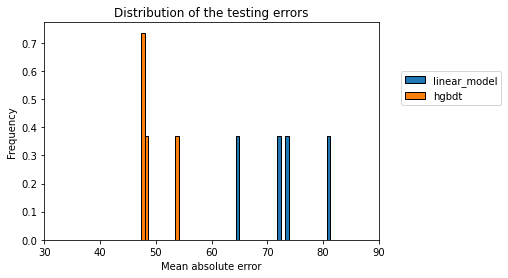

In [17]:
test_errors_linear_model = pd.Series(
    -cv_results_linear_model['test_score'], 
    name="linear_model")
test_errors_hgbdt = pd.Series(
    -cv_results_hgbdt['test_score'], 
    name="hgbdt")
test_errors = pd.concat([
    test_errors_linear_model,
    test_errors_hgbdt
    ], axis=1)
test_errors.plot.hist(bins=50, density=True, edgecolor="black")
plt.legend(bbox_to_anchor=(1.05, 0.8), loc="upper left")
plt.xlabel("Mean absolute error")
plt.xlim(30, 90)
_ = plt.title("Distribution of the testing errors")

Now, we will go in details by picking a single ride for the testing and analyse the predictions of the models for this test ride. To do so, we can reuse the `LeaveOneGroupOut` cross-validation object in the following manner:

In [18]:
from sklearn.metrics import mean_absolute_error

# extract the dataset
cv = LeaveOneGroupOut()
train_indices, test_indices = list(
    cv.split(data, target, groups=groups)
)[0]

data_linear_model_train = data_linear_model.iloc[train_indices]
data_linear_model_test = data_linear_model.iloc[test_indices]

data_train = data.iloc[train_indices]
data_test = data.iloc[test_indices]

target_train = target.iloc[train_indices]
target_test = target.iloc[test_indices]

Now, fit both the linear model and the histogram gradient boosting regressor models on the training data and collect the predictions on the testing data. Make a scatter plot where on the x-axis, you will plot the measured powers (true target) and on the y-axis, you will plot the predicted powers (predicted target). Do two separated plots for each model. We can fit the models, collect the predictions, and make the plots with the following code snippet: 

CPU times: user 148 ms, sys: 19.4 ms, total: 167 ms
Wall time: 33.5 ms


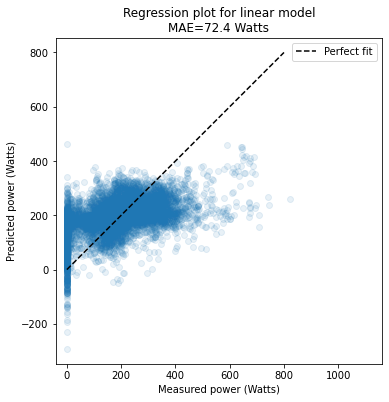

In [19]:
%%time
# fit models, collect predictions and compute errors
linear_model.fit(data_linear_model_train, target_train)
target_predicted_linear_model = linear_model.predict(
    data_linear_model_test)
mae_linear_model = mean_absolute_error(
    target_test, target_predicted_linear_model)

# make regression plots
plt.figure(figsize=(6, 6))
plt.scatter(target_test, 
    target_predicted_linear_model, 
    alpha=0.1)
plt.plot([0, 800], [0, 800], color="black", 
    linestyle="--", label="Perfect fit")
plt.legend()
plt.axis("square")
plt.xlabel("Measured power (Watts)")
plt.ylabel("Predicted power (Watts)")
_ = plt.title(f"Regression plot for linear model\n"
    f"MAE={mae_linear_model:.1f} Watts")

CPU times: user 14.1 s, sys: 823 ms, total: 14.9 s
Wall time: 1.36 s


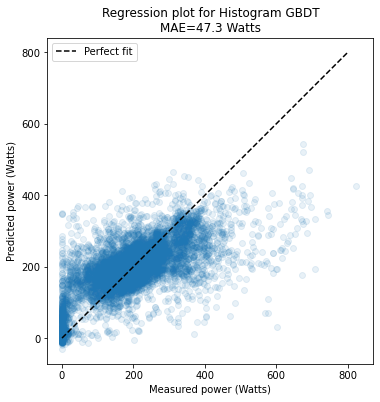

In [20]:
%%time
# fit models, collect predictions and compute errors
hgbdt.fit(data_train, target_train)
target_predicted_hgbdt = hgbdt.predict(
    data_test)
mae_hgbdt = mean_absolute_error(
    target_test, target_predicted_hgbdt)

# make regression plots
plt.figure(figsize=(6, 6))
plt.scatter(target_test, 
    target_predicted_hgbdt, 
    alpha=0.1)
plt.plot([0, 800], [0, 800], color="black", 
    linestyle="--", label="Perfect fit")
plt.legend()
plt.axis("square")
plt.xlabel("Measured power (Watts)")
plt.ylabel("Predicted power (Watts)")
_ = plt.title(f"Regression plot for Histogram GBDT\n"
    f"MAE={mae_hgbdt:.1f} Watts")

By analysing the plots, the linear regressor tends to under-predict samples with high power and makes catastrophic predictions for samples with low power, whereas the histogram gradient boosting regressor tends to under-predict samples with high power.

Let's start by looking at the samples with high power. We see that both the linear model and the histogram gradient boosting regressor always predict power below the measured power. Indeed, high power samples correspond to sprints effort. When measuring speed and acceleration, there is a sort of delay to observe this change while measuring the power directly apply on the pedals will not suffer from such issue.

On the other hand, we see that the linear model predicts catastrophic negative power for samples with a power of 0 Watt. This is due to our modelling. Indeed, the power based on the change of kinetic energy (power needed to accelerate or decelerate) is producing such artifacts. Indeed, we do not model the power loss introduced by heat dissipation when braking to reduce the speed of the bike (to take a bend for instance) and therefore, we get non-sense value for samples with low power. The histogram gradient boosting regressor uses instead the cadence since 0 rpm (rotation per minute) will be linked with 0 Watt produced. 

Now select a portion of the testing data using the following code:

In [21]:
# extract the data and make the prediction
time_slice = slice("2020-08-18 17:00:00", "2020-08-18 17:05:00")

data_test_linear_model_subset = data_linear_model_test[time_slice]
data_test_subset = data_test[time_slice]
target_test_subset = target_test[time_slice]

It allows to select data from 5.00 pm until 5.05 pm. Used the previous fitted models (linear and gradient-boosting regressor) to predict on this portion of the test data. Draw on the same plot the true targets and the predictions of each model.

To produce the desired plots, we can use the following code snippet:

CPU times: user 866 ms, sys: 63.6 ms, total: 930 ms
Wall time: 102 ms


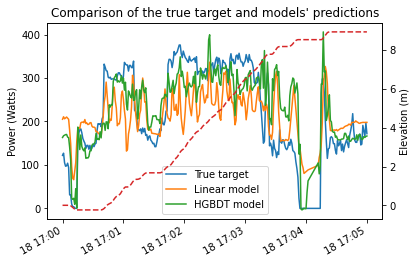

In [22]:
%%time

target_predicted_linear_model = linear_model.predict(
    data_test_linear_model_subset)
target_predicted_hgbdt = hgbdt.predict(
    data_test_subset)

# make the plot
ax = target_test_subset.plot(label="True target")
ax.plot(target_test_subset.index, 
    target_predicted_linear_model, 
    label="Linear model")
ax.plot(target_test_subset.index, 
    target_predicted_hgbdt, 
    label="HGBDT model")
ax.set_ylabel("Power (Watts)")
plt.legend()

# In addition, we add the elevation to show that the data were
# acquired in a hill. This part of the answer was optional.
ax_elevation = ax.twinx()
ax_elevation.plot(target_test_subset.index,
    data_test_subset['slope'].cumsum(), 
    color="tab:red", linestyle="--")
ax_elevation.set_ylabel("Elevation (m)")
_ = plt.title("Comparison of the true target and models' predictions")

By using the previous plot, the histogram gradient boosting regressor is more accurate than the linear model, and the linear model predicts smoother outputs than the histogram gradient boosting regressor.

We see that the linear model has predictions that are more off from the true target than the predictions from the histogram gradient boosting regressor. While the histogram gradient boosting regressor is able to make abrupt changes fo the power, the linear model is unable to predict abrupt changes and need time to output the level of true power.

Again the comparatively bad performance of the linear regression model trained on the physically meaningful features does not necessarily stem from errors in the feature engineering but might come from the GPS measurement errors that prevent a precise estimation of short changes in the speed and acceleration.

The gradient boosting model might be able to workaround those limitations of the GPS errors via the more precise heart rate and cadence measurements.